## DM shape optimization 
### Hardware requirements
- OS Windows 7/10, 64 bit.
- camera Hamamatsu Orca4.3 
- deformable mirror Mirao52e
- sample (fluorescent bead) is illuminated in wide-field, or defocused light sheet (to avoid light sheet walking off the bead)

### Software requirements
- Python 3.6, 64 bit (Anaconda)
- activate virtual environment via `conda activate daospim`
- Hamamatsu DCAM drivers
- Mirao52e dll drivers

### Sample requirements
- fluorescent bead is resistant to bleaching (fluoresence intensity does not drop rapidly over time);
- initial SNR is relatively high (e.g. peak intensity 1000 over noise level of 150);
- only one fluorescent bead is present in the ROI, in both views.

### Algorithm peculiarities
- the image metric is minimized;
- the gain grows in inverse proportion to the (decreasing) metric;
- initial gain should be relatively small to avoid divergence (hopping on big bumps of the gradient);
- the algorithm tracks the position of a bead within the ROI and adjusts the ROI position if the bead drifts over time;
- the shape of DM is averaged between left and right halfs of the aperture, to add stability.

### Disclaimer
This notebook execution depends on particular hardware configuration and experimental conditions, and cannot be exactly reproduced. It was run several times after the original experiment in simulation mode to make the presentation more clear, so the cells are not numbered consecutively.

In [1]:
import ctypes as ct
import sys
sys.path.append('./lib')
import hamamatsu_camera as cam
from mirao52_utils import *
from param_printing import get_params_as_text
import optimization

import time
from skimage.external import tifffile 
import os
import collections

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
#folder for saving results
saveDir = './2020-02-18_optimization_examples_test/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)
    
#define home dir of the code:
homeDir = './'

### Connect to DM and camera

In [4]:
#Load the Mirao52e DLL:
DM = ct.windll.LoadLibrary('./lib/mirao_x64/mirao52e.dll')
dm_nActuators = 52
dm_command = np.zeros(dm_nActuators, dtype=np.float64)

flat_path = homeDir +  './lib/FLAT_MIRAO_0274-01.mro'
dm_command_flat = read_Mirao_commandFile(flat_path, DM)

dm_trigger = ct.c_int32() 
dm_trigger.value = 0
dm_status  = ct.c_int32() 

In [6]:
#open the DM session
assert DM.mro_open(ct.byref(dm_status)), errors[dm_status.value]

In [7]:
#apply flat command 
assert DM.mro_applySmoothCommand(dm_command_flat.ctypes.data_as(ct.POINTER(ct.c_float)),
                                 dm_trigger,ct.byref(dm_status)), errors[dm_status.value]

In [9]:
param_init = cam.DCAMAPI_INIT(0, 0, 0, 0, None, None)
param_init.size = ct.sizeof(param_init)
error_code = cam.dcam.dcamapi_init(cam.ctypes.byref(param_init))
if error_code != cam.DCAMERR_NOERROR:
    raise cam.DCAMException("DCAM initialization failed with error code " + str(error_code))
n_cameras = param_init.iDeviceCount
if n_cameras > 0:
    cam_handle = cam.HamamatsuCamera(camera_id=0)
    print("connected to Camera 0, model: "+ str(cam_handle.getModelInfo(0)) + "\n")

connected to Camera 0, model: C13440-20C



### Setting up camera triggers (optional)
Illumination is triggered by the camera to minimize unnecessary light exposure and bleaching of the sample.

In [10]:
cam_exposure_ms = 20
cam_handle.setPropertyValue("exposure_time", cam_exposure_ms/1000.)
cam_handle.setPropertyValue("readout_speed", 2)

#triggers IN, software mode
cam_handle.setPropertyValue("trigger_mode", 1) #1 - NORMAL, 6 - START
cam_handle.setPropertyValue("trigger_source", 1) # 1 internal, 2 external, 3 software, 4 master pulse
cam_handle.setPropertyValue("trigger_active", 1) # 1 EDGE, 2 LEVEL, 3 SYNCREADOUT
cam_handle.setPropertyValue("master_pulse_trigger_source", 2)  # SOFTWARE

#triggers OUT
cam_handle.setPropertyValue("output_trigger_kind[0]", 2) # 1 LOW, 2 EXPOSURE, 3 PROGRAMABLE, 4 TRIGGER READY, 5 HIGH
cam_handle.setPropertyValue("output_trigger_period[0]", 0.001) # s
cam_handle.setPropertyValue("output_trigger_polarity[0]", 2) # 1 NEGATIVE, 2 POSITIVE

cam_handle.setACQMode("fixed_length", number_frames=1)

Light sheet is generated in the separate software suite, see `../microscope_control/`.

In [11]:
# define named tuples for passing around algorithm settings in a compact form
# Better do it via dictionary next time!
Metric = collections.namedtuple('Metric', ['method1', 'method2', 'weights_method12', 'weights_fwhm_xy', 
                                           'r2_integration_radius', 'normalize_brightness', 'roi_size', 
                                           'tracking', 'peak_estimate'])
Run = collections.namedtuple('Run', ['number', 'gain_ini', 'gain', 'delta_cmd_ini', 'delta_cmd', 'regularization', 'regularization_rate', 
                                     'n_iterations', 'comment', 'actuator_mask'])

Simulation = collections.namedtuple('Simulation',['on', 'snr', 'blob_fwhm_px'])

In [13]:
# ZERO initial
dm_command_zeros = np.zeros(52)
assert DM.mro_applySmoothCommand(dm_command_zeros.ctypes.data_as(ct.POINTER(ct.c_float)),
                                 dm_trigger,ct.byref(dm_status)), errors[dm_status.value]

### Optimization parameters

In [15]:
roi_size = 100
run_settings = Run(number = 1, 
                   gain_ini = 0.035, #starting gain
                   gain = 0.035, # dynamically updated gain (initial value)
                   delta_cmd_ini = 0.002, # initial step
                   delta_cmd = 0.002, # dynamicaly updated step (initial value)
                   regularization = 'left_right_ave', # 'left_right_ave', 'radial_ave', None
                   n_iterations = 50,
                   regularization_rate = 0.25,
                   actuator_mask = None, #None if all actuators are optimized, or 'outer_ring', or 'second_ring'
                   comment = 'dynamic gain')

metric_settings_Lv = Metric(method1 = 'R2Integral', # 'FWHMxy', 'shannonDCT', 'R2Integral' (~8..30), 'R4Integral', 'MSE_simulated'
                         method2 = None, # 'MSE_simulated', 'R2Integral' (~10), 'MSE_gaussian' (~0.002 - 0.005), or None
                         weights_method12 = (1, 0), # initial weights
                         weights_fwhm_xy = (0.5, 0.5),
                         r2_integration_radius = (roi_size / 2) - 10, #only relevant if metric is 'R2Integral'
                         normalize_brightness = True, 
                         roi_size = (roi_size, roi_size, 1), 
                         tracking = 'mass', # 'xy' for peak, 'mass' for center-of-mass, None for no tracking
                         peak_estimate = 'max') # uses 'max' for local maximum, or 'center' for ROI center, initial guess for Gaussian fit
metric_settings_Rv = metric_settings_Lv

simulation = Simulation(on = False, snr = 20, blob_fwhm_px = 5)

### Snap the first image
Make sure that there is only one bead, and it is near the FOV center

In [17]:
# approx coordinates of the bead in the image space
roi_coords_viewLeft = (512, 1050) # x,y
roi_coords_viewRight = (1536, 1050) # 

In [18]:
if not simulation.on:
    image = optimization.snap_image(cam_handle=cam_handle)
else:
    image = np.random.rand(2048,2048)
    print("Simulated image")
    
roi_vR, roi_center_new_vR = optimization.get_roi(image, roi_center = roi_coords_viewRight, 
                                                 roi_size = metric_settings_Lv.roi_size[:2], 
                                                 tracking = metric_settings_Lv.tracking, 
                                                 simulation_settings = simulation)
roi_vL, roi_center_new_vL = optimization.get_roi(image, 
                                                 roi_center = roi_coords_viewLeft, 
                                                 roi_size=metric_settings_Lv.roi_size[:2],
                                                 tracking = metric_settings_Lv.tracking, 
                                                 simulation_settings = simulation)

metric, L view: 31.570
metric, R view: 24.283
updated coords, L view:(509.0, 1051.0)
updated coords, R view:(1506.0, 1065.0)


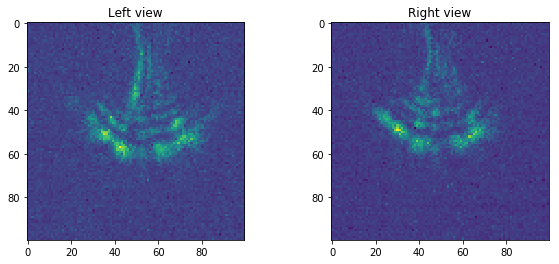

In [137]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].imshow(roi_vL)
ax[1].imshow(roi_vR)
ax[0].set_title('Left view')
ax[1].set_title('Right view')

print('metric, L view: ' + "{0:2.3f}".format(optimization.get_metric(roi_vL, metric_settings_Lv)))
print('metric, R view: ' + "{0:2.3f}".format(optimization.get_metric(roi_vR, metric_settings_Rv)))

print('updated coords, L view:' + str(roi_center_new_vL))
print('updated coords, R view:' + str(roi_center_new_vR))

### Get the values of various metrics (optional)
This allows to set up correct weight coeffieicients, if a mixture of metrics is used.

In [138]:
#metric tests
print('L view')
roi_norm = optimization.normalize_roi(roi_vL, debug_mode=True)
xcenter, ycenter, sigmaX, sigmaY, amp, offset = optimization.get_FWHM_gaussian_fit(roi_norm)
fwhm_x, fwhm_y = optimization.sigma2fwhm(sigmaX), optimization.sigma2fwhm(sigmaY)
print('gaussian fit FWHM(x,y): ' + "{0:2.3f}".format(fwhm_x) + ', ' + "{0:2.3f}".format(fwhm_y))
print('MSE_gaussian: ' + "{0:2.4f}".format(optimization.metric_MSE_gaussian(roi_norm, debug_mode=True)))
print('MAE_gaussian: ' + "{0:2.4f}".format(optimization.metric_MAE_gaussian(roi_norm, debug_mode=True)))
print('R2 integral: ' + "{0:2.4f}".format(optimization.metric_r_power_integral(roi_norm)))

print('\n\n R view')
roi_norm = optimization.normalize_roi(roi_vR, debug_mode=True)
xcenter, ycenter, sigmaX, sigmaY, amp, offset = optimization.get_FWHM_gaussian_fit(roi_norm)
fwhm_x, fwhm_y = optimization.sigma2fwhm(sigmaX), optimization.sigma2fwhm(sigmaY)
print('gaussian fit FWHM(x,y): ' + "{0:2.3f}".format(fwhm_x) + ', ' + "{0:2.3f}".format(fwhm_y))
print('MSE_gaussian: ' + "{0:2.4f}".format(optimization.metric_MSE_gaussian(roi_norm, debug_mode=True)))
print('MAE_gaussian: ' + "{0:2.4f}".format(optimization.metric_MAE_gaussian(roi_norm, debug_mode=True)))
print('R2 integral: ' + "{0:2.4f}".format(optimization.metric_r_power_integral(roi_norm)))

L view
normalize_roi() values (low_percentile, background, peak):50.0,  103.000,  196.000
gaussian fit FWHM(x,y): 6.432, 6.353
Fitted values: xcenter, ycenter, sigmaX, sigmaY, amp, offset:
43.380,  57.962,  2.731,  2.698,  0.800,  0.038
MSE_gaussian: 0.0263
Fitted values: xcenter, ycenter, sigmaX, sigmaY, amp, offset:
43.380,  57.962,  2.731,  2.698,  0.800,  0.038
MAE_gaussian: 0.1045
R2 integral: 31.7551


 R view
normalize_roi() values (low_percentile, background, peak):50.0,  103.000,  205.000
gaussian fit FWHM(x,y): 6.385, 5.470
Fitted values: xcenter, ycenter, sigmaX, sigmaY, amp, offset:
31.005,  49.258,  2.711,  2.323,  0.800,  0.030
MSE_gaussian: 0.0260
Fitted values: xcenter, ycenter, sigmaX, sigmaY, amp, offset:
31.005,  49.258,  2.711,  2.323,  0.800,  0.030
MAE_gaussian: 0.1054
R2 integral: 24.7092


## Optimization loop

In [139]:
DYNAMIC_GAIN = True

roi_center_vL = roi_center_new_vL
roi_center_vR = roi_center_new_vR
dm_cmd_ini = dm_command_zeros

if not simulation.on:
    image = optimization.snap_image(cam_handle=cam_handle)
else:
    image = np.random.rand(2048,2048)
    print("Random image")
    
assert DM.mro_applySmoothCommand(dm_cmd_ini.ctypes.data_as(ct.POINTER(ct.c_float)),
                                     dm_trigger,ct.byref(dm_status)), errors[dm_status.value]
    
roi_Lv, _ = optimization.get_roi(image, roi_center_vL, metric_settings_Lv.roi_size[0:2], metric_settings_Lv.tracking, simulation)
roi_Rv, _ = optimization.get_roi(image, roi_center_vR, metric_settings_Rv.roi_size[0:2], metric_settings_Rv.tracking, simulation)

# INITIALIZE
n_iterations = run_settings.n_iterations
DM_command_array = np.zeros((n_iterations,dm_command_flat.shape[0]))

metric_array = np.zeros((n_iterations, 2))
ROI_array = np.zeros((n_iterations, metric_settings_Lv.roi_size[0], metric_settings_Lv.roi_size[1], 3)) #last dim should be 2, but TIFF saving is then incrorrect

ROIplus_minus_array_Lv = np.zeros((n_iterations, metric_settings_Lv.roi_size[0], metric_settings_Lv.roi_size[1], 2))
ROIplus_minus_array_Rv = np.zeros((n_iterations, metric_settings_Rv.roi_size[0], metric_settings_Rv.roi_size[1], 2))

metric_plus_minus_array_Lv = np.zeros((n_iterations, 2))
metric_plus_minus_array_Rv = np.zeros((n_iterations, 2))

roi_center_array_Lv = np.zeros((n_iterations,2))
roi_center_array_Rv = np.zeros((n_iterations,2))
current_roi_center_Lv = np.asarray(roi_center_vL) 
current_roi_center_Rv = np.asarray(roi_center_vR)

current_command = dm_cmd_ini
increment_cmd = np.zeros(dm_command_flat.shape[0])

debug_roi_low_high = np.zeros((n_iterations,2))

# RUN
for it in range(n_iterations):
    (delta_cmd_array, roi_plus_Lv, roi_plus_Rv, roi_minus_Lv, roi_minus_Rv) \
        = optimization.wiggle_mirror_snap_rois_2views(cam_handle, DM, current_command,
                                                      metric_settings_Lv,
                                                      run_settings,
                                                      current_roi_center_Lv,
                                                      current_roi_center_Rv,
                                                      simulation) 

    m_plus_Lv = optimization.get_metric(roi_plus_Lv, metric_settings_Lv)
    m_plus_Rv = optimization.get_metric(roi_plus_Rv, metric_settings_Rv)
    m_minus_Lv = optimization.get_metric(roi_minus_Lv, metric_settings_Lv)
    m_minus_Rv = optimization.get_metric(roi_minus_Rv, metric_settings_Rv)
    
    delta_cost_function = (m_plus_Lv - m_minus_Lv)*0.5 + (m_plus_Rv - m_minus_Rv)*0.5
    # apply increment only to non-zero deltas (if actuators subset is optimized)
    non_zero_ind = np.where(abs(delta_cmd_array) > 1e-6)
    increment_cmd = np.zeros(52)
    increment_cmd[non_zero_ind] = - run_settings.gain * delta_cost_function * delta_cmd_array[non_zero_ind] 
    new_cmd = current_command + increment_cmd
    
    new_cmd_regularized = optimization.regularize_command(new_cmd, run_settings.regularization,
                                                               run_settings.regularization_rate)
    
    if optimization.safe_voltage(new_cmd_regularized):
        if not simulation.on:
            DM.mro_applySmoothCommand(new_cmd_regularized.ctypes.data_as(ct.POINTER(ct.c_float)),
                                      dm_trigger, ct.byref(dm_status))
    else:
        raise ValueError(str(it) + ': Voltage is outside of safe range.')
        
    #save stuff in RAM
    ROIplus_minus_array_Lv[it,:,:,0] = roi_plus_Lv
    ROIplus_minus_array_Lv[it,:,:,1] = roi_minus_Lv
    ROIplus_minus_array_Rv[it,:,:,0] = roi_plus_Rv
    ROIplus_minus_array_Rv[it,:,:,1] = roi_minus_Rv
    metric_plus_minus_array_Lv[it,:] = (m_plus_Lv, m_minus_Lv)
    metric_plus_minus_array_Rv[it,:] = (m_plus_Rv, m_minus_Rv)
    DM_command_array[it,:] = new_cmd_regularized
    current_command = new_cmd_regularized
    
    #image the new PSFs in both views
    if not simulation.on:
        image = optimization.snap_image(cam_handle=cam_handle)
    else:
        image = np.random.rand(2048,2048)
    roi_Lv, roi_center_Lv = optimization.get_roi(image, current_roi_center_Lv,
                                           metric_settings_Lv.roi_size[:2], 
                                           metric_settings_Lv.tracking,
                                           simulation)
    roi_Rv, roi_center_Rv = optimization.get_roi(image, current_roi_center_Rv,
                                           metric_settings_Rv.roi_size[:2], 
                                           metric_settings_Rv.tracking,
                                           simulation)
    
    ROI_array[it,:,:,0] = roi_Lv
    ROI_array[it,:,:,1] = roi_Rv
    metric_array[it,0] = optimization.get_metric(roi_Lv, metric_settings_Lv)
    metric_array[it,1] = optimization.get_metric(roi_Rv, metric_settings_Rv)
    #update ROI center position
    current_roi_center_Lv = roi_center_Lv
    current_roi_center_Rv = roi_center_Rv
    roi_center_array_Lv[it,:] = current_roi_center_Lv 
    roi_center_array_Rv[it,:] = current_roi_center_Rv 
    # update Run settings for next iteration
    cost_function = 0.5*(metric_array[it,0] + metric_array[it,1])
    if DYNAMIC_GAIN:
        if it == 0:
            cost_function_ini = cost_function
        if DYNAMIC_GAIN: # gain increases as the cost function decreases
            run_settings = run_settings._replace(gain = run_settings.gain_ini * cost_function_ini / cost_function)
    else:
        pass


### Fit 2d gaussian to obtain FWHM estimates

In [ ]:
FIT_FWHM = True

FWHM_xy_array = np.zeros((n_iterations,2,2))
if FIT_FWHM:
    for it in range(n_iterations):
        for iView in [0,1]:
            try:
                roi = optimization.normalize_roi(ROI_array[it,:,:,iView])
                _, _, sigmaX, sigmaY, _, _ = optimization.get_FWHM_gaussian_fit(roi) 
                FWHM_xy_array[it,iView,:] = optimization.sigma2fwhm(sigmaX), optimization.sigma2fwhm(sigmaY)
            except Exception as e:
                print("Excepton:" + str(e) + '\n')
                FWHM_xy_array[it,iView,:] = (None, None)

FWHM_xy_ave = FWHM_xy_array.mean(axis=1)
#best_iter = np.where(FWHM_xy_ave == FWHM_xy_ave.min())[0][0]
#best_iter = np.where(metric_array == metric_array.min())[0][0]

## Plot the optimization results

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


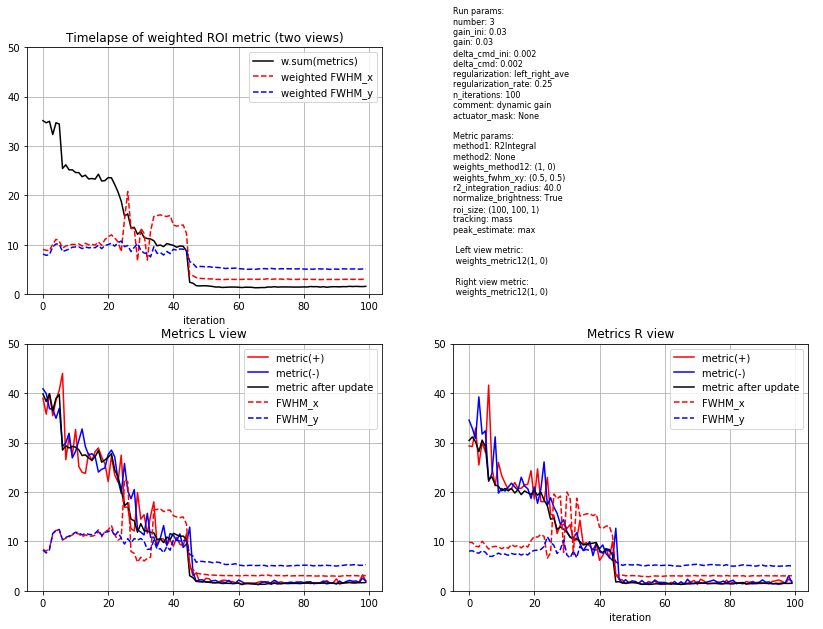

In [17]:
overwrite = True
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(2, 2, 1)
ymin = 0
ymax = 50
ax1.plot(np.sum(metric_array * np.array([0.5, 0.5]), axis = 1),'k', label='w.sum(metrics)')
ax1.plot(FWHM_xy_array[:,0,0]*0.5 
         + FWHM_xy_array[:,1,0]*0.5, '--r', label="weighted FWHM_x")
ax1.plot(FWHM_xy_array[:,0,1]*0.5
         + FWHM_xy_array[:,1,1]*0.5, '--b', label="weighted FWHM_y")
ax1.set_ylim([ymin, ymax])
ax1.legend(loc = 'upper right', ncol = 1)
ax1.set_xlabel('iteration')
ax1.grid(True)
ax1.set_title('Timelapse of weighted ROI metric (two views)')


ax2 = fig.add_subplot(2, 2, 3)
ax2.set_title('Metrics L view')
iView = 0
ax2.plot(metric_plus_minus_array_Lv[:,0], 'r', label = 'metric(+) ')
ax2.plot(metric_plus_minus_array_Lv[:,1], 'b', label = 'metric(-) ')
ax2.plot(metric_array[:,iView], 'k', label = 'metric after update')
ax2.plot(FWHM_xy_array[:,iView,0], '--r', label="FWHM_x")
ax2.plot(FWHM_xy_array[:,iView,1], '--b', label="FWHM_y")
ax2.set_ylim([0, ymax])
ax2.legend()
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title('Metrics R view')
iView = 1
ax3.plot(metric_plus_minus_array_Rv[:,0], 'r', label = 'metric(+) ')
ax3.plot(metric_plus_minus_array_Rv[:,1], 'b', label = 'metric(-) ')
ax3.plot(metric_array[:,iView], 'k', label = 'metric after update')
ax3.plot(FWHM_xy_array[:,iView,0], '--r', label="FWHM_x")
ax3.plot(FWHM_xy_array[:,iView,1], '--b', label="FWHM_y")
ax3.set_ylim([0, ymax])
ax3.legend()
ax3.set_xlabel('iteration')
ax3.grid(True)

ax5 = fig.add_subplot(2, 2, 2)
ax5.axis('off')
ax5.text(0,0, get_params_as_text(run_settings, metric_settings_Lv, simulation)
               + '\n Left view metric: \n weights_metric12' + str(metric_settings_Lv.weights_method12) 
               + '\n\n Right view metric: \n weights_metric12' + str(metric_settings_Rv.weights_method12),
               FontSize = 8)

#save
fname = saveDir + 'Run' + str(run_settings.number) + '_report' 
if overwrite or not os.path.exists(fname + '.png'):
    fig.savefig(fname + '.png',format='png')
    fig.savefig(fname + '.pdf',format='pdf')
else:
    raise ValueError("file already exists!")

### Save ROIs as TIFF files

In [142]:
fname = saveDir + 'ROIs_run' + str(run_settings.number) +  '.tif'
if overwrite or not os.path.exists(fname):
    tifffile.imsave(fname,np.clip(ROI_array, 0, 2**16-1).astype(np.uint16))
else:
    raise ValueError("file already exists!")

#Save DM commands as TIFF float32
DM_commands_2D = np.zeros((n_iterations,8,8),'float32')
for i in range(n_iterations):
    DM_commands_2D[i] = DM_voltage_to_map(DM_command_array[i,:])
    
fname = saveDir + 'DMcmd_run' + str(run_settings.number) + '.tif'
if overwrite or not os.path.exists(fname):
    tifffile.imsave(fname,DM_commands_2D.astype(np.float32) )
else:
    raise ValueError("file already exists!")

fname = saveDir + 'DMcmd_run' + str(run_settings.number) +  '.npy'
if overwrite or not os.path.exists(fname):
    np.save(fname,DM_command_array)
else:
    raise ValueError("file already exists!")

#Save ROIplus, ROIminus side-by-side
ROIs_debug_Lv = np.concatenate((ROIplus_minus_array_Lv[:,:,:,0], ROIplus_minus_array_Lv[:,:,:,1]),axis=2)
ROIs_debug_Rv = np.concatenate((ROIplus_minus_array_Rv[:,:,:,0], ROIplus_minus_array_Rv[:,:,:,1]),axis=2)

fname = saveDir +  'ROIs_plus_minus_debug_Lv_run' + str(run_settings.number) +'.tif'
if overwrite or not os.path.exists(fname):
    tifffile.imsave(fname,np.clip(ROIs_debug_Lv,0,2**16-1).astype(np.uint16) )
else:
    raise ValueError("file already exists!")

fname = saveDir +  'ROIs_plus_minus_debug_Rv_run' + str(run_settings.number) +'.tif'
if overwrite or not os.path.exists(fname):
    tifffile.imsave(fname,np.clip(ROIs_debug_Rv,0,2**16-1).astype(np.uint16) )
else:
    raise ValueError("file already exists!")

In [145]:
# Save the metrics data
fname = saveDir + 'Run' + str(run_settings.number) + '_metric_plus_minus_array_L(R)v.npy'
np.save(fname, np.hstack((metric_plus_minus_array_Lv, metric_plus_minus_array_Rv)))

fname = saveDir + 'Run' + str(run_settings.number) + '_metric_array_L(R)v.npy'
np.save(fname, metric_array)

fname = saveDir + 'Run' + str(run_settings.number) + 'FWHM_xy_array_L(R)v.npy'
np.save(fname, FWHM_xy_array)

## Plot the DM command vector
Positions correspond to DM aperture.

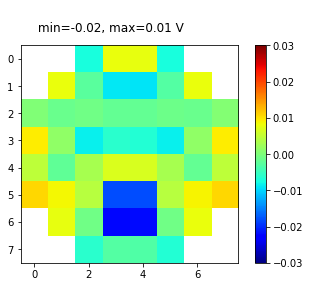

In [20]:
dm_cmd_last = DM_command_array[-10:,:].mean(axis=0)
plotDM(dm_cmd_last, vmin=-0.03,vmax=0.03)

In [150]:
#SAVE the best command
dm_cmd_to_save = dm_cmd_last
fname = "DMcmd_run3(last10ave)"
np.save(saveDir + fname + '.npy', dm_cmd_to_save)

## End of session

In [20]:
#close the DM session
assert DM.mro_close(ct.byref(dm_status)), errors[dm_status.value]

In [21]:
#close camera connection
if cam_handle is not None:
    cam_handle.shutdown()